In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
print(torch.cuda.is_available())

True


In [2]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_lxlconv=False, strides=1):
        #初始化方法接收输入通道数,输出通道数,是否使用1x1卷积和步幅参数
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1) # stride默认=1
        if use_lxlconv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        #定义批归一化层
        self.bn1 = nn.BatchNorm2d(num_channels)  
        self.bn2 = nn.BatchNorm2d(num_channels)
        #设置ReLU激活函数
        #同时设置当 inplace=True 时，激活函数（如ReLU）会直接在输入张量上进行操作，而不是创建一个新的张量。
        #这意味着不再分配额外的内存来存储输出结果，而是直接修改输入数据。
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        #在前向传播中，输入X首先通过conv1和bn1，
        #然后应用ReLU激活函数。接着，再通过conv2和bn2。
        if self.conv3:
            X = self.conv3(X) #如果使用了conv3，则将输入X通过conv3进行处理
        Y += X  #将Y与X相加，形成残差连接，最后应用ReLU激活函数返回结果。           
        return F.relu(Y)   


In [3]:
##same convolution
#blk = Residual(3,3)  
##创建残差块
#X = torch.rand(4,3,6,6)  
#Y=blk(X) #调用 blk 对象的 forward 方法，将输入张量 X 传递给这个残差块进行处理。
#Y.shape

In [4]:
##先是经过cov1,输出形状是(4,6,3,3)
##经过cov2,输出形状还是(4,6,3,3) 
##然后再经过cov3
#blk2 = Residual(3, 6, use_lxlconv=True, strides=2)
#blk(X).shape

In [5]:
#blk3 = Residual(3, 6, use_lxlconv=True, strides=1)
#Y = blk3(X)
#Y.shape

In [6]:
#ResNet模型

#定义一个网络的初始层b1
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3), # 输入通道数是1,输出通道数是64
                   nn.BatchNorm2d(64),nn.ReLU(), #批量归一化,引入非线性
                   nn.MaxPool2d(kernel_size=3,stride=2,padding=1)) #最大池化

# 构建多个残差块
def resnet_block(input_channels, num_channels, num_residuals,  first_block=False):
    blk = []  
    for i in range(num_residuals):
        if i==0 and not first_block: 
            #高宽减半
            blk.append(Residual(input_channels, num_channels, use_lxlconv=True,strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

#b2两个残差块都不减半( 原因是 b1 高宽减半2次） 
#剩下的b3到b5,第一个残差块减半,第二个不减半
b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True)) 
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

net = nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512,10))
#将前面定义的模块组合在一起，构建了一个完整的深度残差网络（ResNet）
#nn.AdaptivaAvgPool2d(((1,1)) 自适应平均池化层
#该层将特征图的空间尺寸自适应地调整为1x1,不论输入特征图的尺寸是多少，输出都将是一个1x1的特征图通道数是512
#nn.Flatten() 展平层
#将1x1的特征图展平为一维向量。对于512个通道数，展平后将得到一个长度为512的一维向量。
#nn.Linear(512,10) 全连接层
#这个全连接层将展平后的特征向量转换为输出的类别数。这里输出大小为10，用来处理10个不同类别的图像。

In [7]:
X = torch.rand(size=(1,1,256,256))
#(样本数, 通道数 , 高, 宽)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 64, 64])
Sequential output shape:	 torch.Size([1, 64, 64, 64])
Sequential output shape:	 torch.Size([1, 128, 32, 32])
Sequential output shape:	 torch.Size([1, 256, 16, 16])
Sequential output shape:	 torch.Size([1, 512, 8, 8])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


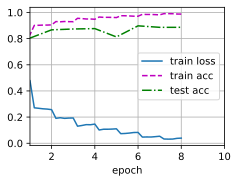

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
#lr是学习率,设置成0.05
#num_epochs 训练的轮次 设置为10
#batch_size 每个批次样本的数量 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
#d2l.load_data_fashion_mnist是一个用于加载 Fashion MNIST 数据集的函数
#batch_size,指定每个批次的大小
#resize=96,将图像大小调整为96x96像素,以便适应网络输入的要求。
#返回值train_iter:用于迭代训练数据的迭代器
#返回值tes_iter：用于迭代测试数据的迭代器
d2l.train_ch6(net, train_iter, test_iter, num_epochs,  lr, d2l.try_gpu())
#d2l.train_ch6 是一个用于训练模型的函数。
#net是要训练的残差模型